In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet
from CustomDataset import get_dataset
from CustomDataset import vec_trans

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp

In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 5*20*20
LEARNINGRATE = 8e-3
GAMMA = 0.9

BATCHSIZE = 256
NUMEPOCHS = 11

LOG_SOFTMAX_VALUES = False

dset = get_dataset('20news-bydate-test')

FILE = 'weights/Model_quicksave40.pt'


class_names = dset.classes
print(class_names)


rand_files = random.sample(range(len(dset)), NUM_MAPS)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
model = ConvNet(LOG_SOFTMAX_VALUES)

model.load_state_dict(torch.load(FILE))
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod, org, h, mode):
    '''
    Computes Loss Function
    '''
    
    
    ### Loss 1
    if mode == 1:
        z = torch.mean((mod[:,h]-org[:,h])**2)
    
    
    
    ### Loss 2
    if mode == 2:
        z = torch.mean((mod[:,:]-org[:,:])**2)
    
    ### Loss 3
    if mode == 3:
        z = mod-org
        z[:,h] = F.relu(org[:,h]-mod[:,h])
        z = torch.mean((F.relu(z))**2)
    
    ### Loss 4
    if mode == 4:
        z = mod-org
        z[:,h] = org[:,h]-mod[:,h]
        z = torch.mean(z)
    
    
    return z

In [5]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, norm=0, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    
    fig = plt.figure(figsize=(width, height))
    ax = plt.gca()
    ax.set_title(title, loc='left')
    tokens = words
    
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    if norm == 0:
        normalized_scores =  scores #/ np.max(np.abs(scores))
    elif norm == 1:
        normalized_scores =  0.5*scores + 0.5
    elif norm == 2:
        normalized_scores =  0.5*(scores/np.max(np.abs(scores))) + 0.5
        
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')



In [6]:
with open('prepositions.txt','r') as f:
    prep = [p.strip() for p in f]
    
print(prep)

['aboard', 'about', 'above', 'across', 'after', 'against', 'along', 'amid', 'among', 'anti', 'around', 'as', 'at', 'before', 'behind', 'below', 'beneath', 'beside', 'besides', 'between', 'beyond', 'but', 'by', 'despite', 'down', 'during', 'except', 'for', 'from', 'in', 'inside', 'into', 'like', 'near', 'of', 'off', 'on', 'onto', 'outside', 'over', 'past', 'per', 'regarding', 'save', 'since', 'than', 'through', 'to', 'toward', 'under', 'underneath', 'unlike', 'until', 'up', 'upon', 'via', 'with', 'within', 'without', 'is', 'was', 'a', 'an', 'the']


In [7]:
def GenRelMap_Basic(x, num_iters=400, lr =8e-3, gam = 0.95):
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    

    s = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s.requires_grad = True
    #s = torch.autograd.Variable(s, requires_grad=True)

    optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(64,1,x.shape[2],1))
    
    for i in range(64):
        n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))
    
    n = torch.as_tensor(n.astype(np.float32)).to(device)
    
    for i in range(num_iters):
                
        data_input = (x_input-n)*s+n
        out = model(data_input)

        loss = 0.5*comp_loss(out, x_out, highest_dim, mode=4)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            s = s.clamp_(0,1) #- s

        scheduler.step()
            
    return s.detach().cpu().numpy()

In [8]:
def GenRelMap_Advanced(x, word_loc, num_iters=400, lr =8e-3, gam = 0.95, lamb = 600, mode=None):
    
    flag = True
    dirr = 0
    inc = 2.0
    
    lw = len(word_loc)
    diff = x.shape[2] - lw
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    
    mask = np.zeros((1,x.shape[2],1))
    mask[0,word_loc,0] = 1
    mask = torch.as_tensor(mask.astype(np.float32)).to(device)
    mask.requires_grad = False
    
    mask2 = -1*np.ones((1,x.shape[2],1))
    mask2[0,word_loc,0] = 1
    mask2 = torch.as_tensor(mask2.astype(np.float32)).to(device)
    mask2.requires_grad = False
    
    ## SETTING NOISE
    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(64,1,x.shape[2],1))

    for i in range(64):
        n[i] = np.tile(vec_trans.matrixify(prep[i],1),(1,1,x.shape[2],1))

    n = torch.as_tensor(n.astype(np.float32)).to(device)

    if mode == 'l1' or mode == 'l1_removed':
        while True:
            
            if mode == 'l1':
                s = np.ones((1,x.shape[2],1))
            elif mode == 'l1_removed':
                s = np.zeros((1,x.shape[2],1))
                
            s[0,word_loc,0] = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)[0,word_loc,0]
            s = torch.as_tensor(s.astype(np.float32)).to(device)
            s.requires_grad = True

            optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
            scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

            for i in range(num_iters):

                data_input = (x_input-n)*s+n
                out = model(data_input)

                loss = 0.5*comp_loss(out, x_out, highest_dim, mode=1) + lamb*(torch.sum(torch.abs(s))-diff)/lw

                optimizer.zero_grad()
                loss.backward()

                ####
                s.grad = s.grad*mask
                ####

                optimizer.step()

                with torch.no_grad():
                    s = s.clamp_(0,1)

                scheduler.step()

            if s.detach().cpu().numpy()[0,word_loc,0].sum()>len(word_loc)*0.35:
                if dirr<0:
                    inc = inc/2
            
                lamb = lamb*(1+inc)
                dirr = 1
                print('1')
            
            elif s.detach().cpu().numpy()[0,word_loc,0].sum()<len(word_loc)*0.15:
                #print(s.detach().cpu().numpy()[0,word_loc,0].sum())
                #print(s)
                #print(lamb)
                
                if dirr > 0:
                    inc = inc/2
            
                lamb = lamb/(1+inc)
                dirr = -1
                print('-1')
            
            else:
                break
            
    if mode == 'linspace' or mode=='linspace_removed':
        count = 0
        
        if mode == 'linspace':
            s = np.ones((1,x.shape[2],1))
        elif mode == 'linspace_removed':
            s = np.zeros((1,x.shape[2],1))
            
        s[0,word_loc,0] = 0.5 + 0.1*np.random.rand(1,x.shape[2],1)[0,word_loc,0]
        s = torch.as_tensor(s.astype(np.float32)).to(device)
        s.requires_grad = True

        optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)
        sa = 0
        for i in range(num_iters):

            data_input = (x_input-n)*s+n
            out = model(data_input)
            
            loss = 0.5*comp_loss(out, x_out, highest_dim, mode=1)
            
            optimizer.zero_grad()
            loss.backward()

            ####
            s.grad = s.grad*mask
            ####
            
            prev_s = s.clone().detach()
            
            optimizer.step()
            
            with torch.no_grad():
                proc = (s+1)*mask2
                indices = np.argsort(proc.detach().cpu().numpy()[0,:,0])[::-1][:lw]
                ind2 = np.argsort(indices)
                s[0,indices[ind2],0] = torch.as_tensor(np.linspace(0, 1, num=lw)[::-1][ind2].astype(np.float32)).to(device)
            
            if torch.all(torch.eq(s,prev_s)):
                count += 1
            else:
                count = 0
            
            if count == 25:
                print('Converged')
                print(i)
                break
                
            scheduler.step()
        
        
    return s.detach().cpu().numpy()

In [18]:
'''
import time

N_PC = 7

rmap_l1 = [None]*20
rmap_l1r = [None]*20
wds = [None]*20
pths = [None]*20

for x in range(20):
    rmap_l1[x] = [0]*N_PC
    rmap_l1r[x] = [0]*N_PC
    wds[x] = [0]*N_PC
    pths[x] = [0]*N_PC
    
counter = [0]*20
_ = 0
'''
while not all(x == N_PC for x in counter):
    
    e = dset.get_words_list(rand_files[_])
    
    if len(e)<40 or len(e)>800:
        _ += 1
        continue
    
    sample, target, path = dset[rand_files[_]]
    sample = dset.get_custom_matrix(rand_files[_])
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if np.argmax(x_out) != target:    
        continue
        
    if counter[target] == N_PC:
        continue
    
    print(counter)
    
    length = sample.shape[2]//3
    
    guider = GenRelMap_Basic(sample, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
    z = np.argsort(guider)[::-1]
    adv = GenRelMap_Advanced(sample, z[:length], num_iters=701, gam=0.995, lr = 8e-3, lamb = 20, mode='l1_removed')[0,:,0]
    
    rmp = np.zeros(sample.shape[2])
    rmp[z[:length]] = adv[z[:length]]
    rmap_l1r[target][counter[target]] = rmp
    
    adv = GenRelMap_Advanced(sample, z[:length], num_iters=701, gam=0.995, lr = 8e-3, lamb = 20, mode='l1')[0,:,0]
    
    rmp = np.zeros(sample.shape[2])
    rmp[z[:length]] = adv[z[:length]]
    rmap_l1[target][counter[target]] = rmp
    
    
    wds[target][counter[target]] = e
    pths[target][counter[target]] = path
    
    counter[target] += 1
    

[0, 1, 3, 2, 2, 1, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 2, 1, 3]
-1
-1
-1
-1
1
[0, 1, 3, 3, 2, 1, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 2, 1, 3]
-1
-1
[0, 1, 3, 3, 2, 2, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 2, 1, 3]
-1
-1
-1
[0, 1, 3, 3, 2, 2, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 3, 1, 3]
-1
-1
-1
-1
-1
[0, 1, 3, 3, 3, 2, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 3, 1, 3]
-1
-1
-1
-1
-1
[0, 2, 3, 3, 3, 2, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 3, 1, 3]
-1
[1, 2, 3, 3, 3, 2, 2, 3, 4, 2, 2, 0, 1, 3, 5, 1, 1, 3, 1, 3]
1
[1, 2, 3, 3, 3, 2, 2, 3, 4, 2, 2, 0, 1, 4, 5, 1, 1, 3, 1, 3]
[1, 2, 3, 3, 3, 2, 2, 3, 4, 2, 2, 0, 1, 5, 5, 1, 1, 3, 1, 3]
[1, 2, 3, 4, 3, 2, 2, 3, 4, 2, 2, 0, 1, 5, 5, 1, 1, 3, 1, 3]
-1
[1, 2, 3, 4, 3, 2, 2, 3, 4, 2, 2, 0, 1, 5, 5, 2, 1, 3, 1, 3]
-1
-1
[1, 2, 3, 4, 3, 2, 2, 3, 4, 3, 2, 0, 1, 5, 5, 2, 1, 3, 1, 3]
-1
[1, 2, 3, 4, 3, 2, 2, 3, 4, 3, 2, 0, 1, 5, 5, 2, 1, 3, 1, 4]
[1, 2, 3, 4, 3, 2, 2, 3, 4, 3, 2, 0, 1, 6, 5, 2, 1, 3, 1, 4]
-1
[1, 2, 3, 4, 3, 3, 2, 3, 4, 3, 2, 0, 1, 6, 5, 2, 1, 3, 1, 4]
-1
-1


In [19]:
np.save('data_combined_seed20.npy',[rmap_l1,rmap_l1r,wds,pths])

In [9]:
[rmap_l1,rmap_l1r,wds,pths] = np.load('data_combined_seed20.npy',allow_pickle=True)

20news-bydate-test/misc.forsale/76493


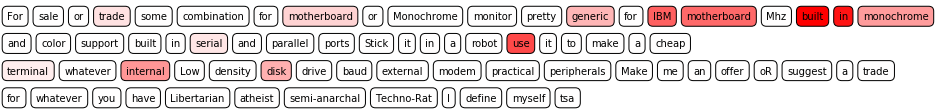

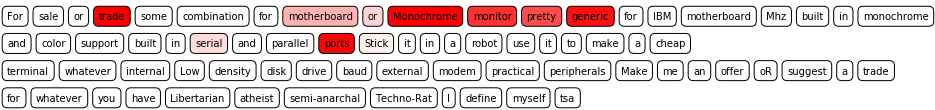

In [10]:
no = 4
cls = 6
print(pths[cls][no])

plot_text_heatmap(wds[cls][no],rmap_l1[cls][no],norm=1)
plot_text_heatmap(wds[cls][no],rmap_l1r[cls][no],norm=1)


In [11]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(160,name='fc1',activation='relu')(x)
    z = Dropout(0.35)(x)
    ou = Dense(20,name='fc2')(z)
    out = Dropout(0.35)(ou)
    k_model = Model(inp, out)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20) 

In [12]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [13]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

In [14]:
analyzers = []

for method, kws in zip(methods, kwargs):
    #print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kws)
    #analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [15]:
from keras.layers import Softmax
import time

test_sample_paths = [pths[6][4]]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path(test_sample_paths[0])[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    

    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    #test_sample_preds[i] = y_hat
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)        ### Add the values along the embedding dimension
        analysis[i, aidx] = a

20news-bydate-test/misc.forsale/76493


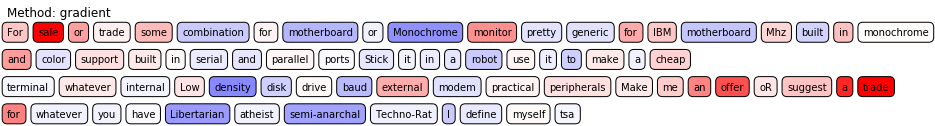

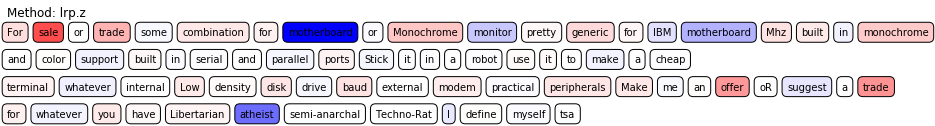

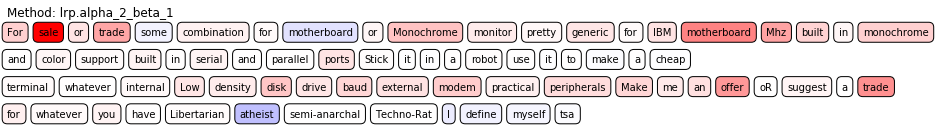

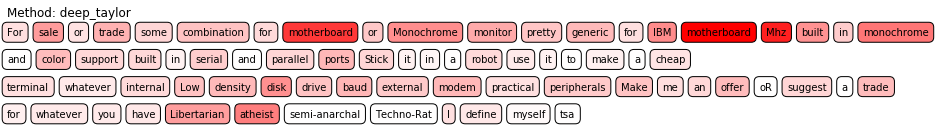

In [16]:
for i, idx in enumerate(test_sample_paths):

    words = dset.data_from_path(idx)[0]   
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=2, title='Method: %s' % method, verbose=0)
        plt.show()

In [17]:
def get_distortion_curve(x,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        order = np.argsort(maps[i])[::-1]
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for j in range(64):
            n[j] = np.tile(vec_trans.matrixify(prep[j],1),(1,1,x.shape[0],1))
        
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            
            for c,k in enumerate(z):
                n[:,0,order[:k],:] = x[order[:k]]
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))
                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                yval[i][c] = comp_loss(out,x_out,highest_dim,mode=1).data.item()
                
    return yval

In [18]:
## Ensuring Keras model = PyTorch Model

x = dset[11][0]
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[  5.710669  -11.601694  -10.80189   -10.243076  -12.503867  -12.017722
  -17.71195    -8.069324   -8.757725   -6.0240746 -11.322091  -10.003626
  -15.980781  -10.340491  -10.901194   -5.84283   -11.021151  -12.648237
   -9.22873    -4.0878973]]


tensor([[  5.7107, -11.6017, -10.8019, -10.2431, -12.5039, -12.0177, -17.7120,
          -8.0693,  -8.7577,  -6.0241, -11.3221, -10.0036, -15.9808, -10.3405,
         -10.9012,  -5.8428, -11.0212, -12.6482,  -9.2287,  -4.0879]],
       device='cuda:0')

In [19]:
w,x = dset.data_from_path(pths[6][4])
m1 = rmap_l1[6][4]
m2 = rmap_l1r[6][4]
y = get_distortion_curve(x,[m1,m2])

In [20]:
y2 = get_distortion_curve(x,analysis[0,:,0])

Text(0, 0.5, 'Distortion')

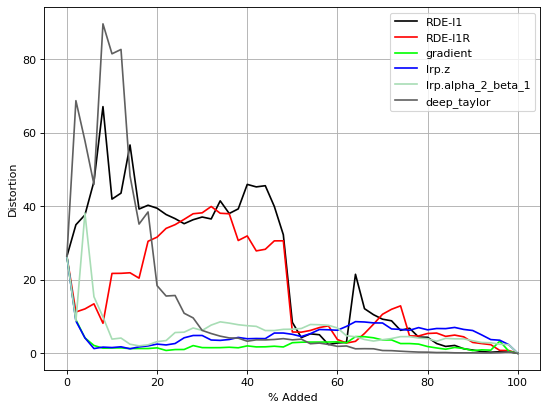

In [21]:
colors = ['#000000','#FF0000','#00FF00','#0000FF','#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,y[0],colors[0])
plt.plot(x_ax,y[1],colors[1])


for i in range(len(y2)):
    plt.plot(x_ax,y2[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')

In [22]:
test_sample_paths = []
for i in range(140):
    test_sample_paths.append(pths[i//7][i%7])

#test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)

for i, ridx in enumerate(test_sample_paths):
 
    x = dset.data_from_path(ridx)[1]
    x = x.reshape((1, -1, 300,1))    
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    
    for aidx, analyzer in enumerate(analyzers):        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a   

In [23]:
N_PC = 7
y=[[np.zeros(51)]*2]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_l1[j][i]
        m2 = rmap_l1r[j][i]
        y[j*N_PC + i] = get_distortion_curve(x,[m1,m2])
        y2[j*N_PC + i] = get_distortion_curve(x,analyzis[j*7+i])

In [24]:
z = np.array(y)
ym = z.mean(axis=0)

In [25]:
z = np.array(y2)
y2m = z.mean(axis=0)
print(y2m.shape)

(4, 51)


Text(0, 0.5, 'Distortion - L1')

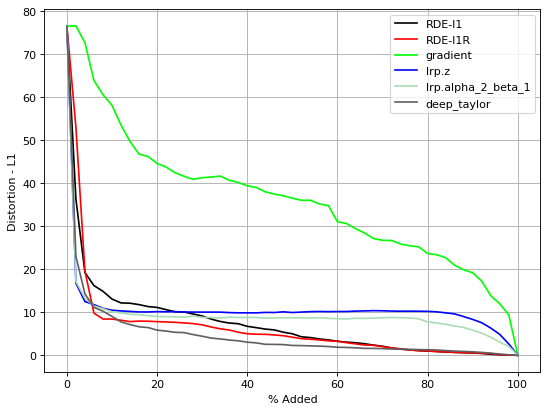

In [26]:
colors = ['#000000','#FF0000','#00FF00','#0000FF','#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym[0],colors[0])
plt.plot(x_ax,ym[1],colors[1])


for i in range(len(y2m)):
    plt.plot(x_ax,y2m[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion - L1')

In [27]:
def get_distortion_curve_l2(x,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        order = np.argsort(maps[i])[::-1]
        
        n = vec_trans.matrixify('a',1)
        n = np.tile(n,(64,1,x.shape[0],1))
        for j in range(64):
            n[j] = np.tile(vec_trans.matrixify(prep[j],1),(1,1,x.shape[0],1))
        
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            
            for c,k in enumerate(z):
                n[:,0,order[:k],:] = x[order[:k]]
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))
                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                yval[i][c] = comp_loss(out,x_out,highest_dim,mode=2).data.item()
                
    return yval

(4, 51)


Text(0, 0.5, 'Distortion - L1')

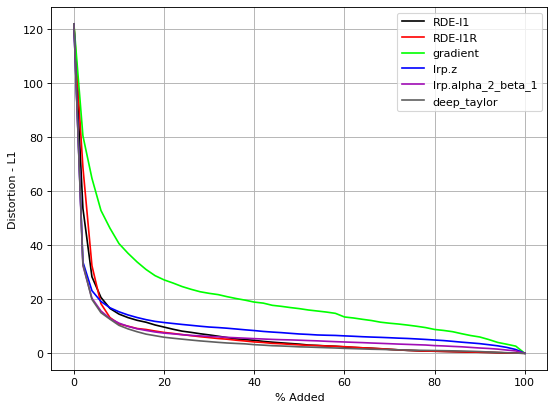

In [28]:
N_PC = 7
y=[[np.zeros(51)]*2]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_l1[j][i]
        m2 = rmap_l1r[j][i]
        y[j*N_PC + i] = get_distortion_curve_l2(x,[m1,m2])
        y2[j*N_PC + i] = get_distortion_curve_l2(x,analyzis[j*7+i])

        z = np.array(y)
ym = z.mean(axis=0)
z = np.array(y2)
y2m = z.mean(axis=0)
print(y2m.shape)

colors = ['#000000','#FF0000','#00FF00','#0000FF','#a00db5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym[0],colors[0])
plt.plot(x_ax,ym[1],colors[1])


for i in range(len(y2m)):
    plt.plot(x_ax,y2m[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion - L1')

Text(0, 0.5, 'Distortion - L2')

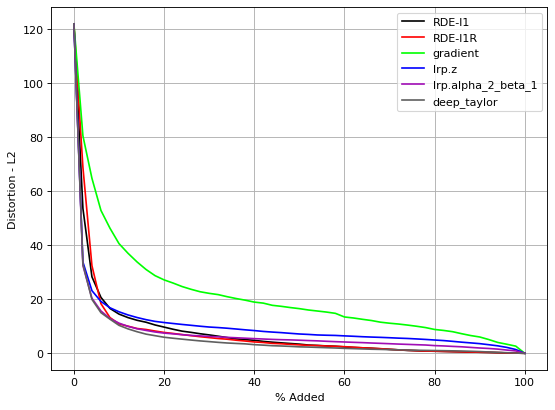

In [29]:
####### CORRECTION FOR ABOVE GRAPH LABEL

colors = ['#000000','#FF0000','#00FF00','#0000FF','#a00db5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym[0],colors[0])
plt.plot(x_ax,ym[1],colors[1])


for i in range(len(y2m)):
    plt.plot(x_ax,y2m[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion - L2')

In [30]:
###### ACC GRAPH
BTCH = 1

def get_acc(x,target,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        #n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        n = np.zeros((BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [31]:
w,x = dset.data_from_path(pths[3][4])
m1 = rmap_l1[3][4]
m2 = rmap_l1r[3][4]
y = get_acc(x,3,[m1,m2])
print(y)

[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])]


In [32]:
N_PC = 7
y_acc=[[np.zeros(11)]*2]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_l1[j][i]
        m2 = rmap_l1r[j][i]
        y_acc[j*N_PC + i] = get_acc(x,j,[m1,m2])
        y2_acc[j*N_PC + i] = get_acc(x,j,analyzis[j*7+i])

In [33]:
z = np.array(y_acc)
yam = z.mean(axis=0)

z = np.array(y2_acc)
y2am = z.mean(axis=0)

Text(0, 0.5, 'Acc')

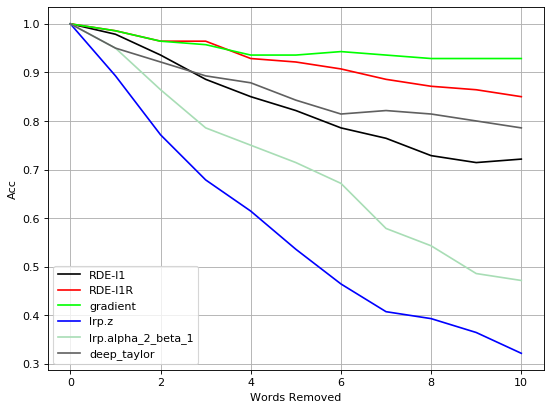

In [34]:
colors = ['#000000','#FF0000','#00FF00','#0000FF','#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(yam[0],colors[0])
plt.plot(yam[1],colors[1])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc')

In [35]:
e, sample = dset.data_from_path('exp.txt')
print(e)

sample = sample[None,None,:,:]

x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
x_out = model(x_input.clone()).detach().cpu()

print(np.argmax(x_out))
print(class_names[np.argmax(x_out)])

length = min(sample.shape[2]//3, 15)
guider = GenRelMap_Basic(sample, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]
z = np.argsort(guider)[::-1]
adv = GenRelMap_Advanced(sample, z[:length], num_iters=701, gam=0.995, lr = 8e-3, lamb = 20, mode='l1')[0,:,0]
rmp_l1 = np.zeros(sample.shape[2])
rmp_l1[z[:length]] = adv[z[:length]]
adv = GenRelMap_Advanced(sample, z[:length], num_iters=701, gam=0.995, lr = 8e-3, lamb = 20, mode='l1_removed')[0,:,0]
rmp_l1r = np.zeros(sample.shape[2])
rmp_l1r[z[:length]] = adv[z[:length]]

['I', 'am', 'a', 'doctor', 'who', 'needs', 'an', 'urgent', 'hockey', 'puck', 'to', 'treat', 'an', 'innocent', 'patient', 'I', 'need', 'to', 'go', 'to', 'the', 'hospital', 'in', 'my', 'ferrari', 'car', 'I', 'am', 'the', 'best', 'doctor', 'there', 'is', 'in', 'the', 'Middle-East', 'Even', 'the', 'God', 'loves', 'me', 'I', 'believe', 'in', 'God', 'and', 'Jesus', 'I', 'am', 'making', 'a', 'medicine', 'for', 'people', 'I', 'love', 'my', 'cars', 'so', 'much', 'I', 'am', 'a', 'professor', 'at', 'Univeristy', 'of', 'Mumbai', 'My', 'guns', 'are', 'always', 'ready', 'to', 'shoot', 'I', 'use', 'Windows', 'X', 'PC', 'I', 'hate', 'Windows', 'PC', 'I', 'like', 'Mac', 'more', 'Actually', 'I', 'am', 'atheist']
tensor(10)
rec.sport.hockey


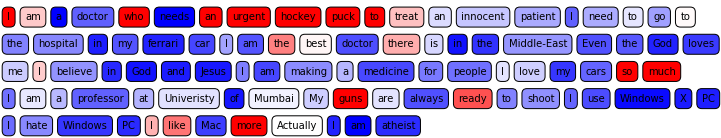

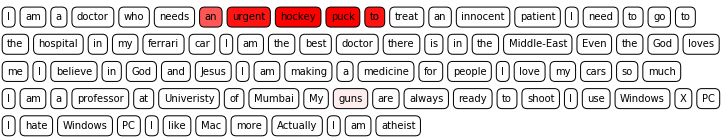

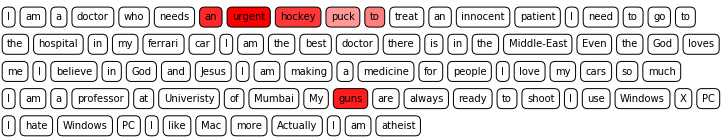

In [36]:
plot_text_heatmap(e,guider)
plot_text_heatmap(e,rmp_l1,norm=1)
plot_text_heatmap(e,rmp_l1r,norm=1)

In [37]:
from keras.layers import Softmax
import time

test_sample_paths = [1]

#test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path('exp.txt')[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    #print(dset.get_custom_matrix(243).shape[0])
    e, x = dset.data_from_path('exp.txt')

    #print(x.shape)
    #print(ridx)
    #_,y,p = dset[ridx]
    t_start = time.time()
    x = x.reshape((1, -1, 300,1))    

    #presm = k_model.predict_on_batch(x)[0] #forward pass without softmax
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        #print(x.shape)
        print(a.shape)
        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review (%.4fs)'% (t_elapsed))

1
(92,)
(92,)
(92,)
(92,)
Review (0.0271s)


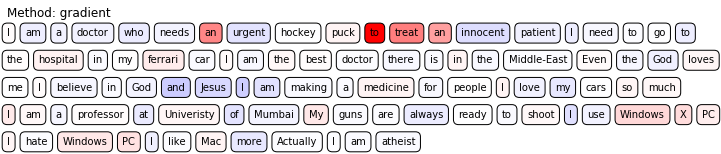

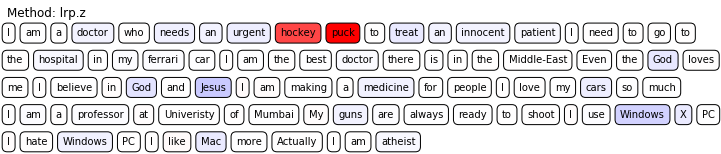

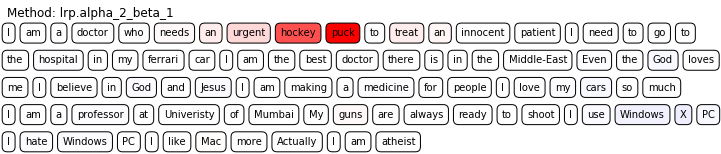

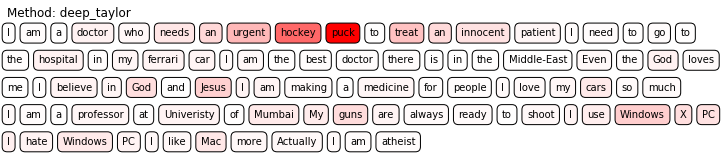

In [38]:
for i, idx in enumerate(test_sample_paths):

    words, sample = dset.data_from_path('exp.txt')
                                
    for j, method in enumerate(methods):
        plot_text_heatmap(words, analysis[i, j].reshape(-1), norm=2, title='Method: %s' % method, verbose=0)
        plt.show()

Text(0, 0.5, 'Acc - Batched')

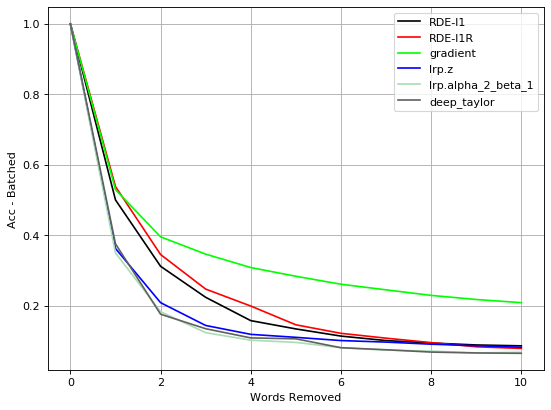

In [39]:
###### ACC GRAPH
BTCH = 64

def get_acc(x,target,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                #print(temp)
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

N_PC = 7
y_acc=[[np.zeros(11)]*2]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        w,x = dset.data_from_path(pths[j][i])
        m1 = rmap_l1[j][i]
        m2 = rmap_l1r[j][i]
        y_acc[j*N_PC + i] = get_acc(x,j,[m1,m2])
        y2_acc[j*N_PC + i] = get_acc(x,j,analyzis[j*7+i])

z = np.array(y_acc)
yam = z.mean(axis=0)

z = np.array(y2_acc)
y2am = z.mean(axis=0)


colors = ['#000000','#FF0000','#00FF00','#0000FF','#a8ddb5','#606060','#4eb3d3','#7bccc4','#a8ddb5','#ccebc5']

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(yam[0],colors[0])
plt.plot(yam[1],colors[1])

for i in range(y2am.shape[0]):
    plt.plot(y2am[i],colors[2+i])
    
plt.legend(['RDE-l1','RDE-l1R','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Acc - Batched')